In [49]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image
import os


class LicensePlateDataset(Dataset):
    '''
    A Pytorch Dataset class to load images, bounding boxes, and keypoints lazily.
    Returns:
    images: torch.Tensor of size (C, H, W)
    gt_bboxes: torch.Tensor of size (max_objects, 4)
    gt_keypoints: torch.Tensor of size (max_objects, 8) # 8 for 4 keypoints (x1, y1, x2, y2, x3, y3, x4, y4)
    gt_classes: torch.Tensor of size (max_objects)
    '''
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform

        self.img_paths = sorted([os.path.join(img_dir, img) for img in os.listdir(img_dir)])
        self.label_paths = sorted([os.path.join(label_dir, label) for label in os.listdir(label_dir)])

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image lazily
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img_tensor = self.transform(img)

        label_path = self.label_paths[idx]
        gt_boxes, gt_keypoints, gt_classes = self.parse_annotation(label_path)

        return img_tensor, gt_boxes, gt_keypoints, gt_classes

    def parse_annotation(self, label_path):
        gt_boxes_all = []
        gt_keypoints_all = []
        gt_classes_all = []

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:
            line_split = line.strip().split()
            # Extract keypoints
            x1, y1, x2, y2, x3, y3, x4, y4 = map(float, line_split[1:])

            # Bounding box calculation
            x_min = min(x1, x2, x3, x4)
            y_min = min(y1, y2, y3, y4)
            x_max = max(x1, x2, x3, x4)
            y_max = max(y1, y2, y3, y4)
            bbox = torch.Tensor([x_min, y_min, x_max, y_max])

            # Keypoints as a flat array of 8 values (x1, y1, x2, y2, x3, y3, x4, y4)
            keypoints = torch.Tensor([x1, y1, x2, y2, x3, y3, x4, y4])

            gt_boxes_all.append(bbox)
            gt_keypoints_all.append(keypoints)
            gt_classes_all.append(0)  # Single class for license plates

        gt_boxes = torch.stack(gt_boxes_all)
        gt_keypoints = torch.stack(gt_keypoints_all)
        gt_classes = torch.tensor(gt_classes_all)

        return gt_boxes, gt_keypoints, gt_classes

In [50]:
from torchvision import transforms


transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((1280, 720))
        ])

train_data = LicensePlateDataset("C:\\Users\\hieuh\\Downloads\\project\\CCPD\\dataset\\1_batch\\images", "C:\\Users\\hieuh\\Downloads\\project\\CCPD\\dataset\\1_batch\\labels", transform= transform)
train_loader = DataLoader(train_data, 2)
next(iter(train_loader))

[tensor([[[[0.3765, 0.4039, 0.4549,  ..., 0.3137, 0.3294, 0.3176],
           [0.3765, 0.4039, 0.4549,  ..., 0.3205, 0.3362, 0.3244],
           [0.3765, 0.4039, 0.4549,  ..., 0.3306, 0.3463, 0.3345],
           ...,
           [0.5541, 0.5541, 0.5541,  ..., 0.6196, 0.6196, 0.6196],
           [0.5445, 0.5445, 0.5445,  ..., 0.6196, 0.6196, 0.6196],
           [0.5412, 0.5412, 0.5412,  ..., 0.6196, 0.6196, 0.6196]],
 
          [[0.4510, 0.4784, 0.5294,  ..., 0.3137, 0.3294, 0.3176],
           [0.4510, 0.4784, 0.5294,  ..., 0.3205, 0.3362, 0.3244],
           [0.4510, 0.4784, 0.5294,  ..., 0.3306, 0.3463, 0.3345],
           ...,
           [0.5541, 0.5541, 0.5541,  ..., 0.6196, 0.6196, 0.6196],
           [0.5445, 0.5445, 0.5445,  ..., 0.6196, 0.6196, 0.6196],
           [0.5412, 0.5412, 0.5412,  ..., 0.6196, 0.6196, 0.6196]],
 
          [[0.5098, 0.5373, 0.5882,  ..., 0.3137, 0.3294, 0.3176],
           [0.5098, 0.5373, 0.5882,  ..., 0.3205, 0.3362, 0.3244],
           [0.5098, 0.53

In [51]:
for img_batch, gt_bboxes_batch, gt_keypoints_batch ,gt_classes_batch in train_loader:
    img_data_all = img_batch
    gt_bboxes_all = gt_bboxes_batch
    gt_keypoints_all = gt_keypoints_batch
    gt_classes_all = gt_classes_batch
    break

img_data_all = img_data_all[:2]
gt_bboxes_all = gt_bboxes_all[:2]
gt_keypoints_all = gt_keypoints_all[:2]
gt_classes_all = gt_classes_all[:2]

gt_keypoints_all.shape

torch.Size([2, 1, 8])

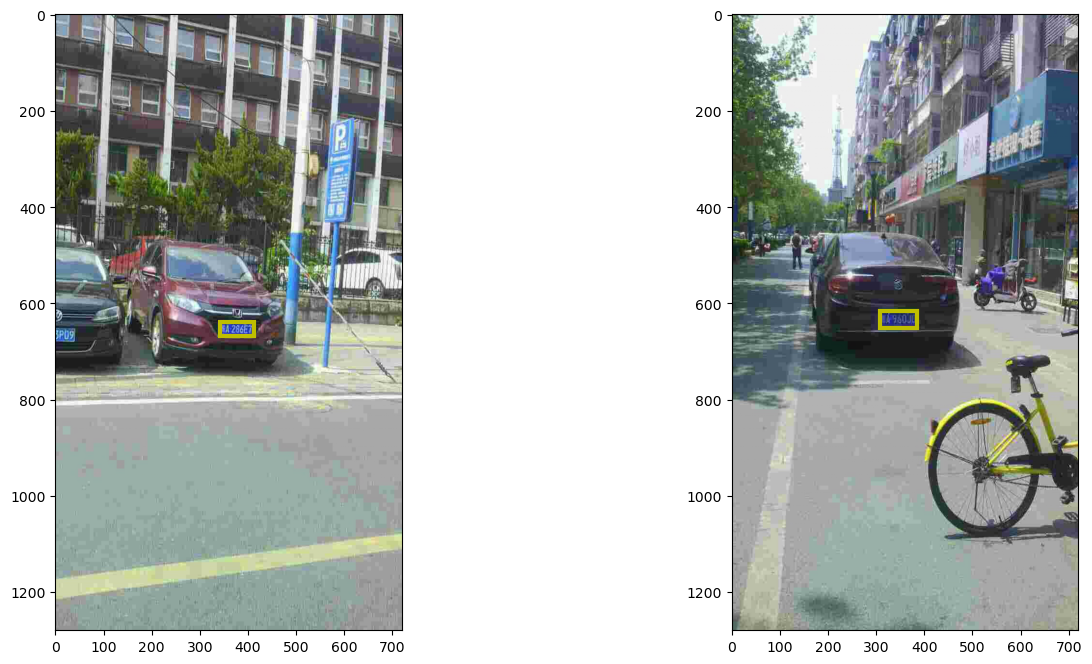

In [52]:
from model.LPD.Faster_RCNN.utils import *
from matplotlib import pyplot as plt


nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_all, fig, axes)
fig, _ = display_bbox(gt_bboxes_all[0], fig, axes[0])
fig, _ = display_bbox(gt_bboxes_all[1], fig, axes[1])

In [53]:
from model.LPD.Faster_RCNN.model import FeatureExtractor
device = 'cuda' if torch.cuda.is_available() else 'cpu'

backbone = FeatureExtractor(backbone= "vgg16", pretrained=True, freeze_backbone= True).to(device)

In [64]:
out = backbone(img_data_all.to(device))
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)
out_c, out_h

(512, 40)

In [55]:
img_width = 720
img_height = 1280
img_size = (img_height, img_width)
out_size = (out_h, out_w)
n_classes = 1
roi_size = (2, 2)

In [60]:
from config import config
faster_rcnn_model = config['model']['LPD'](img_size, out_size, out_c, n_classes, roi_size, backbone).to(device)
faster_rcnn_model.load_state_dict(torch.load("rcnn.pt"))

C:\Users\hieuh\AppData\Local\Temp\ipykernel_19552\3311987907.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  faster_rcnn_model.load_state_dict(torch.load("rcnn.pt"))


<All keys matched successfully>

In [57]:
import torch
import torch.optim as optim
from tqdm import tqdm

def training_loop(model, learning_rate, train_dataloader, n_epochs):
    # Xác định thiết bị (GPU nếu có, ngược lại CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Khởi tạo optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Đặt mô hình ở chế độ huấn luyện
    model.train()

    # Danh sách lưu trữ loss cho mỗi epoch
    loss_list = []

    for epoch in tqdm(range(n_epochs), desc='Training Epochs'):
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_keypoints_batch ,gt_classes_batch in train_dataloader:
            # Di chuyển dữ liệu lên thiết bị
            img_batch = img_batch.to(device)
            gt_bboxes_batch = gt_bboxes_batch.to(device)
            gt_classes_batch = gt_classes_batch.to(device)

            # Forward pass: tính toán loss
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

            # Backpropagation và cập nhật tham số
            optimizer.zero_grad()  # Đặt lại gradient
            loss.backward()        # Tính gradient
            optimizer.step()       # Cập nhật tham số

            # Cộng dồn loss cho epoch hiện tại
            total_loss += loss.item()

        # Thêm loss của epoch hiện tại vào danh sách
        loss_list.append(total_loss)

        # Hiển thị loss của epoch
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {total_loss:.4f}")

    return loss_list


In [58]:
# learning_rate = 0.0001
# n_epochs = 50
# loss_list = training_loop(detector, learning_rate, train_loader, n_epochs)

In [61]:
faster_rcnn_model.eval()
proposals_final, conf_scores_final, classes_final = faster_rcnn_model.inference(img_batch, conf_thresh=0.9, nms_thresh=0.05)
proposals_final

[tensor([[10.5958, 19.9641, 12.7620, 20.9946]], device='cuda:0'),
 tensor([[ 9.5990, 19.2862, 11.9526, 20.3463]], device='cuda:0')]

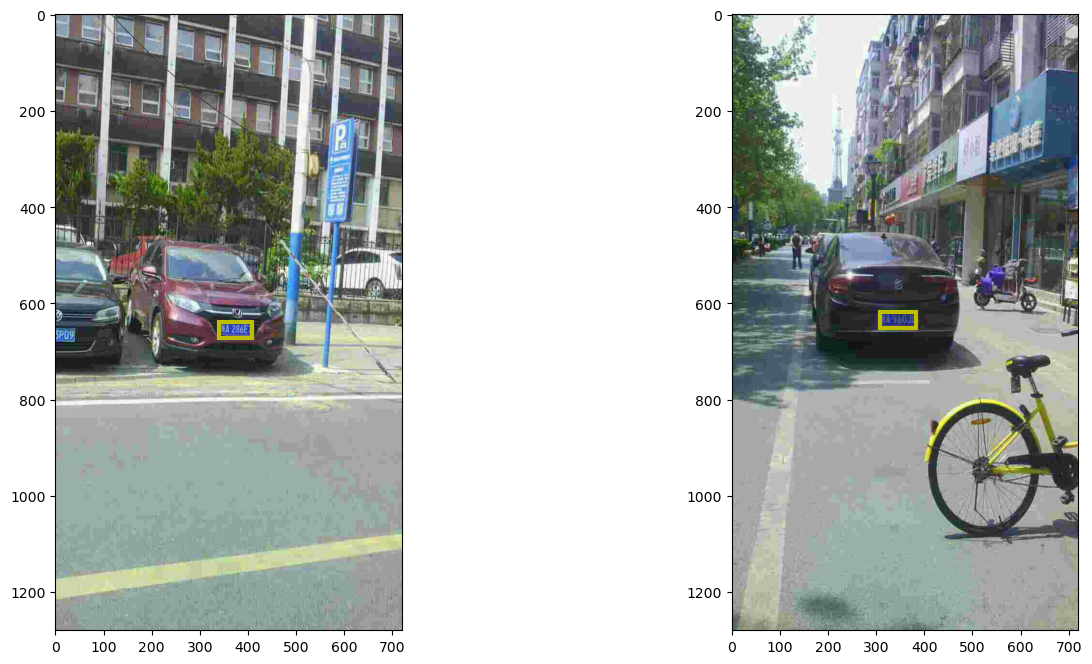

In [62]:
# project proposals to the image space
width_scale_factor = img_width // out_w
height_scale_factor = img_height // out_h

prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch, fig, axes)
fig, _ = display_bbox(prop_proj_1, fig, axes[0])
fig, _ = display_bbox(prop_proj_2, fig, axes[1])

In [16]:
# def calculate_accuracy(detections, gt_classes):
#     correct_predictions = 0
#     total_predictions = 0

#     for detected_boxes, gt in zip(detections, gt_classes):
#         if len(detected_boxes) == 0:  # Kiểm tra nếu không có bounding box nào
#             continue
        
#         total_predictions += 1

#         # Lấy lớp dự đoán từ bounding box đầu tiên
#         detected_class = detected_boxes[0][-1]  # Lớp có thể ở phần tử cuối cùng của bounding box
#         # Nếu detected_class là tensor có nhiều phần tử, lấy phần tử đầu tiên
#         if detected_class.ndimension() > 0:  # Kiểm tra nếu detected_class không phải là scalar
#             detected_class = detected_class[0]  # Lấy phần tử đầu tiên
        
#         if detected_class.item() == gt:  # Chuyển tensor về giá trị số
#             correct_predictions += 1

#     accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
#     return accuracy


In [17]:
# def evaluation_loop(model, dataloader):
#     # Chuyển mô hình sang chế độ đánh giá
#     model.eval()
    
#     device = next(model.parameters()).device  # Lấy thiết bị của mô hình
#     total_loss = 0
#     all_detections = []
#     all_gt_classes = []

#     with torch.no_grad():  # Tắt gradient để tiết kiệm bộ nhớ
#         for img_batch, gt_bboxes_batch, gt_keypoints_batch, gt_classes_batch in dataloader:
#             # Di chuyển dữ liệu lên thiết bị
#             img_batch = img_batch.to(device)
#             gt_bboxes_batch = gt_bboxes_batch.to(device)
#             gt_classes_batch = gt_classes_batch.to(device)

#             # Tính toán loss
#             loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)
#             total_loss += loss.item()

#             # Dự đoán từ mô hình
#             detections = model.inference(img_batch)
#             all_detections.extend(detections)

#             # Lưu trữ các lớp thực tế
#             all_gt_classes.extend(gt_classes_batch.cpu().numpy())  # Chuyển về CPU để lưu trữ

#     # Tính toán độ chính xác hoặc các chỉ số khác
#     accuracy = calculate_accuracy(all_detections, all_gt_classes)

#     return total_loss, accuracy


In [18]:
# # Giả sử bạn đã huấn luyện mô hình và có train_dataloader và test_dataloader
# n_epochs = 10
# learning_rate = 0.001


# # Đánh giá mô hình trên tập dữ liệu kiểm tra
# total_loss, accuracy = evaluation_loop(detector, train_loader)

# # Hiển thị kết quả
# print(f"Total Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")
